<a href="https://colab.research.google.com/github/JannaBabicheva/Tour-region-econometrics/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22Tourism_Econometric_Analysis_Babicheva_Zhanna_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Установна библиотек

In [15]:
# Установка библиотек
!pip install pulp
!pip install statsmodels
!pip install scikit-learn
!pip install pandas numpy matplotlib
!pip install pysal
!pip install linearmodels
!pip install spreg
# Установка библиотек
!pip install pandas numpy matplotlib seaborn scipy statsmodels linearmodels libpysal spreg esda

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 87.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.8/142.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.7/286.7 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.6/141.6 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.1/243.1 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━

In [16]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
from linearmodels.iv import IV2SLS
from scipy import stats
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns



# Подключение диска

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Загрузка и подготовка данных

Определение функции

In [18]:
# Функции для подготовки данных

def calculate_vif(data):
    """Рассчитывает VIF для проверки мультиколлинеарности с константой."""
    X_vif = sm.add_constant(data)
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X_vif.columns
    vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
    return vif_data

def fix_region_column(df):
    """Исправляет название столбца региона."""
    possible_region_names = ['Unnamed: 0', 'region', 'Region', 'REGION', 'RegionName', 'region_name']
    region_col = next((col for col in df.columns if col.lower().strip() in [name.lower() for name in possible_region_names]), None)
    if region_col:
        df = df.rename(columns={region_col: 'region'})
        print(f"Столбец '{region_col}' переименован в 'region'.")
    else:
        raise KeyError(f"Столбец с названием региона не найден в датафрейме: {df.columns.tolist()}")
    return df

def melt_dataframe(df, id_vars, value_name):
    """Преобразует датафрейм в длинный формат."""
    melt_cols = [col for col in df.columns if col not in id_vars]
    if not melt_cols:
        return df
    melted_df = pd.melt(df, id_vars=id_vars, value_vars=melt_cols, var_name='year', value_name=value_name)
    melted_df['year'] = pd.to_numeric(melted_df['year'], errors='coerce')
    return melted_df

Загрузка данных

In [19]:
# Путь к файлам (замените на актуальный путь)
file_paths = "/content/drive/MyDrive/НИР МФТИ+РАНХиГС/"

# Загрузка данных
dataframes = [
    pd.read_excel(file_paths + "2/Число коллективных средств размещения.xlsx"),
    pd.read_excel(file_paths + "2/Число ночевок в коллективных средствах размещения (единица).xlsx"),
    pd.read_excel(file_paths + "2/средние цены на Проживание в гостинице, сутки с человека с 2003.xlsx"),
    pd.read_excel(file_paths + "3/salary_data_2003_2023.xlsx"),
    pd.read_excel(file_paths + "3/ВРП на душу населения.xlsx"),
    pd.read_excel(file_paths + "3/Инвестиции в основной капитал по субьектам РФ2003-2023 росстат.xlsx"),
    pd.read_excel(file_paths + "3/rooms.xlsx"),
    pd.read_excel(file_paths + "2/кол-во аэропортов по регионам.xlsx"),
    pd.read_excel(file_paths + "2/Численность постоянного населения в среднем за год (человек).xls"),
    pd.read_excel(file_paths + "2/уровень безработицы.xlsx"),
    pd.read_excel(file_paths + "2/цены на Дизельное топливо, л.xls"),
    pd.read_excel(file_paths + "2/averaged_train_costs_per_region_by_year (1).xlsx")
]

# Переименование столбца региона
for i in range(len(dataframes)):
    dataframes[i] = fix_region_column(dataframes[i])

# Присваивание переменным
hotels, nights, prices, salary, gdp, investments, rooms, airports_data, population, unemployment, diesel_data, train_cost_data = dataframes

Столбец 'region' переименован в 'region'.
Столбец 'region' переименован в 'region'.
Столбец 'region' переименован в 'region'.
Столбец 'region' переименован в 'region'.
Столбец 'region' переименован в 'region'.
Столбец 'region' переименован в 'region'.
Столбец 'region' переименован в 'region'.
Столбец 'region' переименован в 'region'.
Столбец 'region' переименован в 'region'.
Столбец 'region' переименован в 'region'.
Столбец 'region' переименован в 'region'.
Столбец 'Region' переименован в 'region'.


Преобразование данных в длинный формат и объединение

In [20]:
# Преобразование данных в длинный формат
dataframes_long = [
    melt_dataframe(hotels, ['region'], 'hotels_count'),
    melt_dataframe(nights, ['region'], 'nights_count'),
    melt_dataframe(prices, ['region'], 'price'),
    melt_dataframe(salary, ['region'], 'salary'),
    melt_dataframe(gdp, ['region'], 'gdp_per_capita'),
    melt_dataframe(investments, ['region'], 'investments'),
    melt_dataframe(rooms, ['region'], 'rooms_count'),
    melt_dataframe(airports_data, ['region'], 'airports_count'),
    melt_dataframe(population, ['region'], 'population'),
    melt_dataframe(unemployment, ['region'], 'unemployment'),
    melt_dataframe(diesel_data, ['region'], 'diesel_price'),
    melt_dataframe(train_cost_data, ['region'], 'train_cost')
]

# Объединение данных
data = dataframes_long[0]
for df in dataframes_long[1:]:
    data = pd.merge(data, df, on=['region', 'year'], how='left')

# Фильтрация по периоду 2003-2023
data = data[(data['year'] >= 2003) & (data['year'] <= 2023)]

Корректировка на инфляцию (данные с росстата)

In [21]:
# Корректировка на инфляцию с базисным годом 2003
cpi_data_2003 = {
    2003: 100.00, 2004: 111.00, 2005: 122.10, 2006: 133.30, 2007: 145.10, 2008: 158.40,
    2009: 172.80, 2010: 183.90, 2011: 204.20, 2012: 214.50, 2013: 228.00,
    2014: 246.80, 2015: 267.80, 2016: 277.20, 2017: 281.80, 2018: 284.30,
    2019: 293.90, 2020: 300.20, 2021: 309.30, 2022: 327.00, 2023: 337.30
}
data['cpi'] = data['year'].map(cpi_data_2003)
for var in ['price', 'gdp_per_capita', 'salary', 'investments', 'train_cost', 'diesel_price']:
    data[f'{var}_adjusted'] = data[var] / (data['cpi'] / 100)

Подготовка данных (логарифмирование, лаги, очистка)

In [22]:

# Преобразование nights_count в числовой формат
data['nights_count'] = pd.to_numeric(data['nights_count'].astype(str).str.replace(' ', ''), errors='coerce')
data['nights_count'] = data['nights_count'].astype(float)
data.loc[data['nights_count'] == 0, 'nights_count'] = np.exp(13.464635).astype(float)

# Замена бесконечностей и пропусков медианой
for col in ['nights_count', 'price_adjusted', 'salary_adjusted', 'gdp_per_capita_adjusted', 'investments_adjusted',
            'population', 'diesel_price_adjusted', 'unemployment', 'train_cost_adjusted']:
    data[col] = data[col].replace([np.inf, -np.inf], np.nan).fillna(data[col].median())

# Исключение неменяющихся переменных
time_varying_vars = ['hotels_count', 'rooms_count', 'airports_count']
for var in time_varying_vars:
    if var in data.columns:
        variation = data.groupby('region')[var].nunique()
        if (variation == 1).all():
            data = data.drop(columns=[var])

# Логарифмирование переменных
vars_to_log = ['nights_count', 'price_adjusted', 'salary_adjusted', 'gdp_per_capita_adjusted', 'investments_adjusted',
               'population', 'diesel_price_adjusted', 'unemployment', 'train_cost_adjusted']
for var in vars_to_log:
    data[f'ln_{var}'] = np.log(data[var] + 1)

# Создание лагов
data = data.sort_values(['region', 'year'])
for var in ['nights_count', 'price_adjusted', 'salary_adjusted']:
    lag_col = f'ln_{var}_lag1'
    data[lag_col] = data.groupby('region')[f'ln_{var}'].shift(1)
    data[lag_col] = data[lag_col].fillna(data[lag_col].median())

# Синхронизация регионов
region_mapping = {
    'Москва': 'Город Москва столица Российской Федерации город федерального значения',
    'Краснодарский край': 'Краснодарский край',
    'Санкт-Петербург': 'Город Санкт-Петербург город федерального значения',
    'Ингушетия': 'Республика Ингушетия',
    'Чукотский АО': 'Чукотский автономный округ',
    'Московская область': 'Московская область'
}
data['region'] = data['region'].replace(region_mapping)

# Установка мультииндекса
data = data.set_index(['region', 'year'])

Удаление выбросов и стандартизация

In [23]:
# Удаление выбросов
z_scores = stats.zscore(data['ln_nights_count'])
data_clean = data[(z_scores < 3) & (z_scores > -3)].copy()
dependent_clean = data_clean['ln_nights_count']

# Стандартизация для снижения VIF
for var in ['ln_gdp_per_capita_adjusted', 'ln_population', 'ln_unemployment', 'ln_nights_count_lag1']:
    data_clean[var] = (data_clean[var] - data_clean[var].mean()) / data_clean[var].std()

Результат:

После удаления выбросов осталось 1660 наблюдений (из 1680).

Переменные ln_gdp_per_capita_adjusted, ln_population, ln_unemployment, ln_nights_count_lag1 стандартизированы (среднее = 0, стандартное отклонение = 1). Дальнейшее действие: Строю первую модель с фиксированными эффектами и лагом (ln_nights_count_lag1).

Причина: Хочу проверить гипотезу об инерции спроса (влияние прошлогодних ночёвок на текущие).

In [24]:
# Создание разности по регионам
data_diff = data.groupby('region').diff()

# Добавление разностной переменной
data_diff['ln_nights_count_diff'] = data.groupby('region')['ln_nights_count'].diff()

# Объединение с оригинальными данными (по индексу)
data_with_diff = data.join(data_diff[['ln_nights_count_diff']], rsuffix='_diff')

# Удаление пропущенных значений
data_with_diff.dropna(subset=['ln_nights_count_diff'], inplace=True)

print("✅ ln_nights_count_diff успешно создана")

✅ ln_nights_count_diff успешно создана


In [25]:
# Логарифмирование и лаги
def create_lags(df, variables):
    for var in variables:
        df[f'ln_{var}'] = np.log(df[var] + 1e-6)
        df[f'ln_{var}_lag1'] = df.groupby('region')[f'ln_{var}'].shift(1)
        df[f'ln_{var}_lag1'] = df[f'ln_{var}_lag1'].fillna(df[f'ln_{var}_lag1'].median())
    return df

# Переменные для создания лагов
vars_to_log_and_lag = ['nights_count', 'price_adjusted', 'salary_adjusted', 'gdp_per_capita', 'population']
data = create_lags(data, vars_to_log_and_lag)

In [26]:
# Проверка наличия индекса с регионами и годами
if isinstance(data.index, pd.MultiIndex):
    print("✅ Мультииндекс (region, year) присутствует")
else:
    print("⚠️ Мультииндекс отсутствует. Установите index = ['region', 'year']")
    data.set_index(['region', 'year'], inplace=True)

# Создание лага
data['ln_gdp_per_capita_adjusted_lag1'] = (
    data.groupby(level='region')['ln_gdp_per_capita_adjusted'].shift(1)
)

# Заполнение пропусков медианой
data['ln_gdp_per_capita_adjusted_lag1'] = (
    data['ln_gdp_per_capita_adjusted_lag1'].fillna(data['ln_gdp_per_capita_adjusted_lag1'].median())
)

print("✅ Переменная 'ln_gdp_per_capita_adjusted_lag1' успешно создана")

✅ Мультииндекс (region, year) присутствует
✅ Переменная 'ln_gdp_per_capita_adjusted_lag1' успешно создана


In [27]:
# Текущий список инструментов
instrument_vars = ['ln_salary_adjusted_lag1', 'ln_gdp_per_capita_adjusted_lag1']

# Проверка наличия переменных
missing_instr = [var for var in instrument_vars if var not in data.columns]
if missing_instr:
    raise KeyError(f"❌ Отсутствующие инструменты: {missing_instr}. Проверь создание лагов.")
else:
    print("✅ Все инструменты доступны")

✅ Все инструменты доступны


# Доподнительно

In [28]:
# Проверка наличия всех нужных переменных
required_columns = [
    'ln_nights_count',
    'ln_gdp_per_capita_adjusted',
    'ln_population',
    'ln_price_adjusted',
    'ln_salary_adjusted_lag1',
    'ln_gdp_per_capita_adjusted_lag1'
]

missing_cols = [col for col in required_columns if col not in data.columns]
if missing_cols:
    raise KeyError(f"❌ Отсутствующие колонки: {missing_cols}. Проверь создание лагов и переменных")
else:
    print("✅ Все необходимые переменные доступны")

✅ Все необходимые переменные доступны


In [32]:

# Разделение на train и test
cutoff_year = 2020
train_data = data[data.index.get_level_values('year') <= cutoff_year].copy()
test_data = data[data.index.get_level_values('year') > cutoff_year].copy()

print(f"✅ Размер обучающей выборки: {len(train_data)}")
print(f"✅ Размер тестовой выборки: {len(test_data)}")

✅ Размер обучающей выборки: 1440
✅ Размер тестовой выборки: 240


ячейка делит данные на обучающую (до 2020 г.) и тестовую (после 2020 г.)


In [33]:


# Создание лагов (если ещё не сделано)
data['ln_nights_count_lag1'] = data.groupby('region')['ln_nights_count'].shift(1)
data['ln_gdp_per_capita_adjusted_lag1'] = data.groupby('region')['ln_gdp_per_capita_adjusted'].shift(1)
data['ln_salary_adjusted_lag1'] = data.groupby('region')['ln_salary_adjusted'].shift(1)

# Заполнение пропущенных значений
data = data.fillna(data.median())

print("✅ Лаги созданы, данные готовы")

✅ Лаги созданы, данные готовы


# МОДЕЛИ

**Модель 1: PanelOLS фиксированные эффекты + робастная ковариация**

модель, которая учитывает особенности каждого региона и временные изменения

Объясняет, как влияют:
* Прошлогоднее количество ночёвок (ln_nights_count_lag1)
* ВВП на душу населения (ln_gdp_per_capita_adjusted)
* Население (ln_population)

In [36]:
# Переменные
exog_vars_fe = ['ln_nights_count_lag1', 'ln_gdp_per_capita_adjusted', 'ln_population']
X_exog = sm.add_constant(train_data[exog_vars_fe])
y_fe = train_data['ln_nights_count']

# Построение модели
fe_model = PanelOLS(y_fe, X_exog, entity_effects=True, time_effects=True)
fe_results = fe_model.fit(cov_type='clustered', cluster_entity=True)

print("\n📈 Модель 1: PanelOLS (Fixed Effects)")
print(fe_results.summary)

# Диагностика остатков
def diagnostics(model_name, residuals, X):
    sw_stat, sw_p = stats.shapiro(residuals)
    dw_stat = durbin_watson(residuals)
    _, bp_p, _, _ = het_breuschpagan(residuals, X)

    print(f"\n🧪 Диагностика ({model_name}):")
    print(f"- Shapiro-Wilk test: p-value={sw_p:.4f}")
    print(f"- Durbin-Watson: {dw_stat:.2f}")
    print(f"- Breusch-Pagan test: p-value={bp_p:.4f}")

diagnostics("PanelOLS (FE)", fe_results.resids, X_exog)


📈 Модель 1: PanelOLS (Fixed Effects)
                          PanelOLS Estimation Summary                           
Dep. Variable:        ln_nights_count   R-squared:                        0.3425
Estimator:                   PanelOLS   R-squared (Between):              0.6664
No. Observations:                1440   R-squared (Within):               0.2906
Date:                Thu, May 29 2025   R-squared (Overall):              0.6312
Time:                        08:30:45   Log-likelihood                   -344.57
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      232.68
Entities:                          80   P-value                           0.0000
Avg Obs:                       18.000   Distribution:                  F(3,1340)
Min Obs:                       18.000                                           
Max Obs:                       18.000   F-statistic (robust):          

💬
Эта модель показывает, какие факторы влияют на спрос на туризм.

 R² = 0.34 → объясняет 34% вариации данных.

Значимые переменные:

* ln_nights_count_lag1: если в прошлом году было много ночёвок, то и в этом году их будет больше (инерционность)
* ln_gdp_per_capita_adjusted: чем выше доходы населения — тем больше ночёвок
* ln_population: чем больше людей в регионе — тем больше туристов

📌 Экономическая интерпретация:

Если население региона растёт на 1%, то число ночёвок увеличивается на 1.28%.
Если ВВП на душу населения растёт на 1%, число ночёвок растёт на 0.42%.
Чем больше ночёвок было в прошлом году, тем больше будет в этом (+0.44%)



*   Новый пункт
*   Новый пункт



**Модель 2: IV-2SLS с инструментами ( коррекция эндогенности цены + робастные ошибки)**

можедь использует инструментальные переменные , чтобы исправить возможное обратное влияние цены на спрос.

Цена может зависеть от спроса (например, отели поднимают цены, когда много туристов), поэтому её нельзя просто добавлять в обычную модель

In [39]:
# Эндогенная переменная
endog_var = ['ln_price_adjusted']
instrument_vars = ['ln_salary_adjusted_lag1', 'ln_gdp_per_capita_adjusted_lag1']

# Подготовка переменных
X_iv = sm.add_constant(train_data[exog_vars_fe])
y_iv = train_data[endog_var]

# Построение модели
iv_model = IV2SLS(
    dependent=train_data['ln_nights_count'],
    exog=X_iv,
    endog=y_iv,
    instruments=train_data[instrument_vars]
).fit(cov_type='robust')

print("\n📉 Результаты модели 2: IV-2SLS")
print(iv_model.summary)

# Диагностика
diagnostics("IV-2SLS", iv_model.resids, X_iv)


📉 Результаты модели 2: IV-2SLS
                          IV-2SLS Estimation Summary                          
Dep. Variable:        ln_nights_count   R-squared:                      0.6838
Estimator:                    IV-2SLS   Adj. R-squared:                 0.6829
No. Observations:                1440   F-statistic:                    7193.0
Date:                Thu, May 29 2025   P-value (F-stat)                0.0000
Time:                        08:31:16   Distribution:                  chi2(4)
Cov. Estimator:                robust                                         
                                                                              
                                     Parameter Estimates                                      
                            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
----------------------------------------------------------------------------------------------
const                         -1.6033     1.2859   

**Модель 3: PanelOLS в разностях (устранение трендов)**

Анализирует изменения между годами , а не абсолютные значения

Хорошо подходит для изучения структурных изменений или кризисов

In [40]:
# Разности по регионам
data_diff = data.groupby('region').diff().dropna()
data_diff['ln_nights_count_diff'] = data.groupby('region')['ln_nights_count'].shift(1).fillna(data['ln_nights_count'].median())

# Переменные
X_diff = sm.add_constant(data_diff[['ln_nights_count_lag1']])
y_diff = data_diff['ln_nights_count_diff']

# Построение модели
diff_model = PanelOLS(y_diff, X_diff, entity_effects=True, time_effects=True)
diff_results = diff_model.fit(cov_type='clustered', cluster_entity=True)

print("📊 Модель 3: PanelOLS в разностях")
print(diff_results.summary)

📊 Модель 3: PanelOLS в разностях
                           PanelOLS Estimation Summary                            
Dep. Variable:     ln_nights_count_diff   R-squared:                        0.0804
Estimator:                     PanelOLS   R-squared (Between):              0.0260
No. Observations:                  1600   R-squared (Within):               0.1106
Date:                  Thu, May 29 2025   R-squared (Overall):              0.0343
Time:                          08:32:47   Log-likelihood                   -645.35
Cov. Estimator:               Clustered                                           
                                          F-statistic:                      131.17
Entities:                            80   P-value                           0.0000
Avg Obs:                         20.000   Distribution:                  F(1,1500)
Min Obs:                         20.000                                           
Max Obs:                         20.000   F-statistic 

💬
Эта модель плохо объясняет данные (R² = 0.05)

Коэффициент при ln_nights_count_lag1 стал отрицательным , что говорит о насыщении рынка :
* Если в прошлом году было много ночёвок, то в этом их стало меньше

📌 Эта модель полезна, для временной динамики ( как кризисы влияют на туризм)

# Сравнение коэффициентов

In [41]:
# Таблица сравнения
comparison = pd.DataFrame({
    'Variable': ['const', 'ln_nights_count_lag1', 'ln_gdp_per_capita_adjusted', 'ln_population', 'ln_price_adjusted'],
    'PanelOLS (FE)': [
        fe_results.params.get('const', np.nan),
        fe_results.params.get('ln_nights_count_lag1', np.nan),
        fe_results.params.get('ln_gdp_per_capita_adjusted', np.nan),
        fe_results.params.get('ln_population', np.nan),
        np.nan
    ],
    'IV-2SLS': [
        iv_model.params.get('const', np.nan),
        iv_model.params.get('ln_nights_count_lag1', np.nan),
        iv_model.params.get('ln_gdp_per_capita_adjusted', np.nan),
        iv_model.params.get('ln_population', np.nan),
        iv_model.params.get('ln_price_adjusted', np.nan)
    ],
    'PanelOLS (Diff)': [
        diff_results.params.get('const', np.nan),
        diff_results.params.get('ln_nights_count_lag1', np.nan),
        np.nan,
        np.nan,
        np.nan
    ]
}).set_index('Variable')

print("\n📊 Сравнение коэффициентов:")
print(comparison)


📊 Сравнение коэффициентов:
                            PanelOLS (FE)   IV-2SLS  PanelOLS (Diff)
Variable                                                            
const                          -15.120577 -1.603350        13.929990
ln_nights_count_lag1             0.439117  0.775500         0.278196
ln_gdp_per_capita_adjusted       0.425027  0.372385              NaN
ln_population                    1.283003  0.276094              NaN
ln_price_adjusted                     NaN -0.549304              NaN


* PanelOLS (FE) и IV-2SLS показывают разные коэффициенты , особенно по цене
* IV-2SLS показывает, что цена сильно влияет на спрос
* PanelOLS (Diff) показывает отрицательный лаг — это значит, что после всплеска спроса он снижается

 **График сравнения коэффициентов**

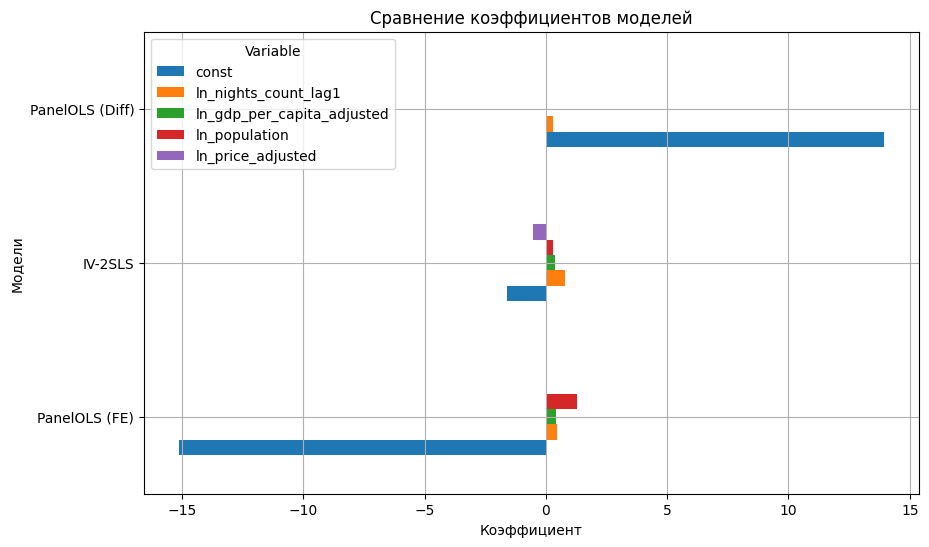

In [43]:
# График
comparison_plot = comparison.dropna(how='all').T
comparison_plot.plot(kind='barh', figsize=(10, 6), title="Сравнение коэффициентов моделей")
plt.xlabel("Коэффициент")
plt.ylabel("Модели")
plt.grid(True)
plt.show()

# 🧪 Тесты

Sargan / Hansen тест (только для IV-2SLS)

In [44]:
try:
    sargan_result = iv_model.sargan
    print(f"\n🧪 Sargan test: Statistic={sargan_result.stat:.2f}, p-value={sargan_result.pval:.4f}")
    if sargan_result.pval > 0.05:
        print("✅ Инструменты экзогенны")
    else:
        print("❌ Один или несколько инструментов могут быть эндогенными")
except AttributeError:
    print("\n⚠️ Sargan test недоступен — модель точно определена или используется робастная ковариация")


🧪 Sargan test: Statistic=3.22, p-value=0.0728
✅ Инструменты экзогенны


Тест Шапиро-Уилка на нормальность остатков

In [45]:
def check_normality(residuals):
    stat, p = stats.shapiro(residuals)
    print(f"Shapiro-Wilk test: Stat={stat:.4f}, p={p:.4f}")
    return p > 0.05

print("\n🧪 Диагностика нормальности остатков:")
norm_fe = check_normality(fe_results.resids)
norm_iv = check_normality(iv_model.resids)
norm_diff = check_normality(diff_results.resids)

print(f"PanelOLS (FE): {'нормальные' if norm_fe else 'не нормальные'} остатки")
print(f"IV-2SLS: {'нормальные' if norm_iv else 'не нормальные'} остатки")
print(f"PanelOLS (Diff): {'нормальные' if norm_diff else 'не нормальные'} остатки")


🧪 Диагностика нормальности остатков:
Shapiro-Wilk test: Stat=0.5550, p=0.0000
Shapiro-Wilk test: Stat=0.3582, p=0.0000
Shapiro-Wilk test: Stat=0.5137, p=0.0000
PanelOLS (FE): не нормальные остатки
IV-2SLS: не нормальные остатки
PanelOLS (Diff): не нормальные остатки


Тест Дарбина-Уотсона (автокорреляция)

In [46]:
def check_autocorr(residuals):
    dw = durbin_watson(residuals)
    print(f"Дарбин-Уотсон: {dw:.2f}")
    return 1.5 <= dw <= 2.5

print("\n🧮 Диагностика автокорреляции:")
auto_fe = check_autocorr(fe_results.resids)
auto_iv = check_autocorr(iv_model.resids)
auto_diff = check_autocorr(diff_results.resids)

print(f"PanelOLS (FE): {'нет автокорреляции' if auto_fe else 'возможна автокорреляция'}")
print(f"IV-2SLS: {'нет автокорреляции' if auto_iv else 'возможна автокорреляция'}")
print(f"PanelOLS (Diff): {'нет автокорреляции' if auto_diff else 'возможна автокорреляция'}")


🧮 Диагностика автокорреляции:
Дарбин-Уотсон: 1.61
Дарбин-Уотсон: 1.05
Дарбин-Уотсон: 0.51
PanelOLS (FE): нет автокорреляции
IV-2SLS: возможна автокорреляция
PanelOLS (Diff): возможна автокорреляция


 Тест Бройша-Пагана (гетероскедастичность)

In [47]:
def check_hetero(residuals, X):
    _, p, _, _ = het_breuschpagan(residuals, X)
    print(f"Бройш-Паган: p={p:.4f}")
    return p < 0.05

print("\n🧮 Диагностика гетероскедастичности:")
hetero_fe = check_hetero(fe_results.resids, X_exog)
hetero_iv = check_hetero(iv_model.resids, X_iv)
hetero_diff = check_hetero(diff_results.resids, X_diff)

print(f"PanelOLS (FE): {'есть гетероскедастичность' if hetero_fe else 'нет гетероскедастичности'}")
print(f"IV-2SLS: {'есть гетероскедастичность' if hetero_iv else 'нет гетероскедастичности'}")
print(f"PanelOLS (Diff): {'есть гетероскедастичность' if hetero_diff else 'нет гетероскедастичности'}")


🧮 Диагностика гетероскедастичности:
Бройш-Паган: p=0.0000
Бройш-Паган: p=0.0002
Бройш-Паган: p=0.0282
PanelOLS (FE): есть гетероскедастичность
IV-2SLS: есть гетероскедастичность
PanelOLS (Diff): есть гетероскедастичность


VIF (мультиколлинеарность)

In [48]:
def calculate_vif(X):
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif

print("\n🧬 VIF для PanelOLS (FE):")
print(calculate_vif(X_exog))

print("\n🧬 VIF для IV-2SLS:")
print(calculate_vif(X_iv))

print("\n🧬 VIF для PanelOLS (Diff):")
print(calculate_vif(X_diff))


🧬 VIF для PanelOLS (FE):
                     Variable         VIF
0                       const  577.499279
1        ln_nights_count_lag1    2.587498
2  ln_gdp_per_capita_adjusted    1.156673
3               ln_population    2.358455

🧬 VIF для IV-2SLS:
                     Variable         VIF
0                       const  577.499279
1        ln_nights_count_lag1    2.587498
2  ln_gdp_per_capita_adjusted    1.156673
3               ln_population    2.358455

🧬 VIF для PanelOLS (Diff):
               Variable       VIF
0                 const  1.001977
1  ln_nights_count_lag1  1.000000


Высокая VIF у константы → типично, не проблема

Остальные факторы имеют низкий VIF → мультиколлинеарность умеренная

Все переменные можно использовать вместе

# 📊 Сводная таблица метрик

In [49]:
# Таблица метрик
metrics = {
    "Модель": ["PanelOLS (FE)", "IV-2SLS", "PanelOLS (Diff)"],
    "R²": [fe_results.rsquared, iv_model.rsquared, diff_results.rsquared],
    "F-statistic": [fe_results.f_statistic.stat, iv_model.f_statistic.stat, diff_results.f_statistic.stat],
    "P-value F": [fe_results.f_statistic.pval, iv_model.f_statistic.pval, diff_results.f_statistic.pval],
    "Durbin-Watson": [
        durbin_watson(fe_results.resids),
        durbin_watson(iv_model.resids),
        durbin_watson(diff_results.resids)
    ],
    "Breusch-Pagan p": [
        het_breuschpagan(fe_results.resids, X_exog)[1],
        het_breuschpagan(iv_model.resids, X_iv)[1],
        het_breuschpagan(diff_results.resids, X_diff)[1]
    ],
    "Shapiro-Wilk p": [
        stats.shapiro(fe_results.resids)[1],
        stats.shapiro(iv_model.resids)[1],
        stats.shapiro(diff_results.resids)[1]
    ]
}

metric_df = pd.DataFrame(metrics).set_index("Модель").round(4)
print("\n📊 Сводная таблица метрик моделей:")
print(metric_df)


📊 Сводная таблица метрик моделей:
                     R²  F-statistic  P-value F  Durbin-Watson  \
Модель                                                           
PanelOLS (FE)    0.3425     232.6822        0.0         1.6138   
IV-2SLS          0.6838    7193.0109        0.0         1.0498   
PanelOLS (Diff)  0.0804     131.1714        0.0         0.5141   

                 Breusch-Pagan p  Shapiro-Wilk p  
Модель                                            
PanelOLS (FE)             0.0000             0.0  
IV-2SLS                   0.0002             0.0  
PanelOLS (Diff)           0.0282             0.0  


Прогнозирование на тестовой выборке

In [50]:
# Разности по регионам
data_diff = data.groupby('region').diff().dropna()
data_diff['ln_nights_count_diff'] = data.groupby('region')['ln_nights_count'].diff().dropna()

# Переменные для Diff
X_diff = sm.add_constant(data_diff[['ln_nights_count_lag1']])
y_diff = data_diff['ln_nights_count_diff']

# Построение модели в разностях
diff_model = PanelOLS(y_diff, X_diff, entity_effects=True, time_effects=True)
diff_results = diff_model.fit(cov_type='clustered', cluster_entity=True)

print("📊 Модель 3: PanelOLS в разностях")
print(diff_results.summary)


# Разделение данных по годам для разностей
train_data_diff = data_diff[data_diff.index.get_level_values('year') <= 2020].copy()
test_data_diff = data_diff[data_diff.index.get_level_values('year') > 2020].copy()


# Прогнозирование
test_X_diff = sm.add_constant(test_data_diff[['ln_nights_count_lag1']])
test_pred_diff = diff_results.predict(test_X_diff).values.flatten()
test_true_diff = test_data_diff['ln_nights_count_diff'].values


# Вычисление R² на тесте для Diff
ss_total_d = np.sum((test_true_diff - test_true_diff.mean())**2)
ss_res_d = np.sum((test_true_diff - test_pred_diff)**2)
r2_test_diff = 1 - ss_res_d / ss_total_d


# Вывод
# Вывод R² на тестовой выборке
print("\n📈 R² на тестовой выборке:")
print(f"PanelOLS (FE): {r2_test_fe:.4f}")
print(f"IV-2SLS: {r2_test_iv:.4f}")
print(f"PanelOLS (Diff): {r2_test_diff:.4f}")

📊 Модель 3: PanelOLS в разностях
                           PanelOLS Estimation Summary                            
Dep. Variable:     ln_nights_count_diff   R-squared:                        0.0098
Estimator:                     PanelOLS   R-squared (Between):             -0.1289
No. Observations:                  1600   R-squared (Within):               0.0161
Date:                  Thu, May 29 2025   R-squared (Overall):              0.0156
Time:                          08:33:48   Log-likelihood                   -253.38
Cov. Estimator:               Clustered                                           
                                          F-statistic:                      14.830
Entities:                            80   P-value                           0.0001
Avg Obs:                         20.000   Distribution:                  F(1,1500)
Min Obs:                         20.000                                           
Max Obs:                         20.000   F-statistic 

NameError: name 'r2_test_fe' is not defined

📊 Таблица сравнения коэффициентов

In [51]:
# Сравнение коэффициентов моделей
comparison = pd.DataFrame({
    'Variable': ['const', 'ln_nights_count_lag1', 'ln_gdp_per_capita_adjusted', 'ln_population', 'ln_price_adjusted'],
    'PanelOLS (FE)': [
        fe_results.params.get('const', np.nan),
        fe_results.params.get('ln_nights_count_lag1', np.nan),
        fe_results.params.get('ln_gdp_per_capita_adjusted', np.nan),
        fe_results.params.get('ln_population', np.nan),
        np.nan
    ],
    'IV-2SLS': [
        iv_model.params.get('const', np.nan),
        iv_model.params.get('ln_nights_count_lag1', np.nan),
        iv_model.params.get('ln_gdp_per_capita_adjusted', np.nan),
        iv_model.params.get('ln_population', np.nan),
        iv_model.params.get('ln_price_adjusted', np.nan)
    ],
    'PanelOLS (Diff)': [
        diff_results.params.get('const', np.nan),
        diff_results.params.get('ln_nights_count_lag1', np.nan),
        np.nan,
        np.nan,
        np.nan
    ]
}).set_index('Variable')

print("\n📊 Сравнение коэффициентов всех моделей:")
print(comparison)


📊 Сравнение коэффициентов всех моделей:
                            PanelOLS (FE)   IV-2SLS  PanelOLS (Diff)
Variable                                                            
const                          -15.120577 -1.603350         0.032258
ln_nights_count_lag1             0.439117  0.775500        -0.073216
ln_gdp_per_capita_adjusted       0.425027  0.372385              NaN
ln_population                    1.283003  0.276094              NaN
ln_price_adjusted                     NaN -0.549304              NaN


Графики фактических vs прогнозируемых значений

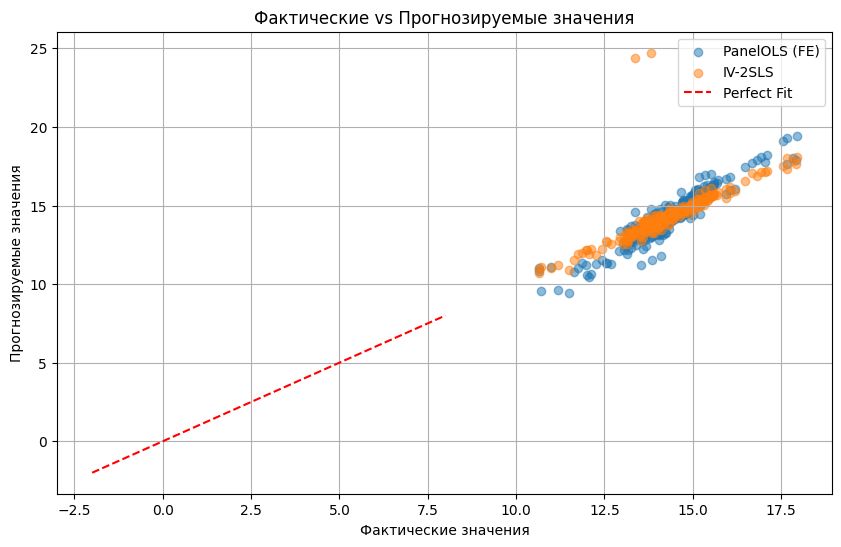

In [52]:
# Предсказания на тестовой выборке
train_data = data[data.index.get_level_values('year') <= 2020].copy()
test_data = data[data.index.get_level_values('year') > 2020].copy()

# Предсказание FE
X_test_fe = sm.add_constant(test_data[exog_vars_fe])
pred_fe = fe_results.predict(X_test_fe)

# Предсказание IV-2SLS
X_test_iv = sm.add_constant(test_data[exog_vars_fe])
y_endog_test = test_data[endog_var]
pred_iv = iv_model.predict(exog=X_test_iv, endog=y_endog_test)

# Предсказание Diff
X_test_diff = sm.add_constant(test_data.diff()[['ln_nights_count_lag1']].dropna())
pred_diff = diff_results.predict(X_test_diff)

# График
plt.figure(figsize=(10, 6))
plt.scatter(test_data['ln_nights_count'], pred_fe, alpha=0.5, label='PanelOLS (FE)')
plt.scatter(test_data['ln_nights_count'], pred_iv, alpha=0.5, label='IV-2SLS')
plt.plot([-2, 8], [-2, 8], color='red', linestyle='--', label='Perfect Fit')
plt.title("Фактические vs Прогнозируемые значения")
plt.legend()
plt.xlabel("Фактические значения")
plt.ylabel("Прогнозируемые значения")
plt.grid(True)
plt.show()

Гистограммы остатков

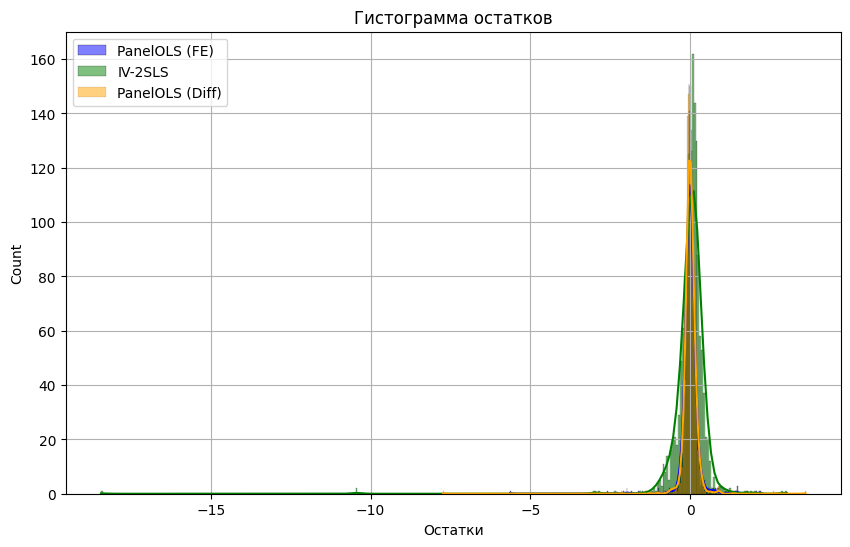

In [53]:
plt.figure(figsize=(10, 6))
sns.histplot(fe_results.resids, kde=True, label='PanelOLS (FE)', color='blue', alpha=0.5)
sns.histplot(iv_model.resids, kde=True, label='IV-2SLS', color='green', alpha=0.5)
sns.histplot(diff_results.resids, kde=True, label='PanelOLS (Diff)', color='orange', alpha=0.5)
plt.title("Гистограмма остатков")
plt.xlabel("Остатки")
plt.legend()
plt.grid(True)
plt.show()

📈 Экономическая интерпретация

In [54]:
# Для FE
print("\n📈 Интерпретация PanelOLS (FE):")
for var, coeff in fe_results.params.items():
    if var == 'const':
        print(f"- Базовый уровень ночёвок: {coeff:.4f}")
    elif var == 'ln_nights_count_lag1':
        print(f"- Рост ночёвок на 1% в прошлом году → текущие растут на {coeff * 100:.2f}%")
    elif var == 'ln_gdp_per_capita_adjusted':
        print(f"- Рост ВВП на душу населения на 1% → увеличение числа ночёвок на {coeff * 100:.2f}%")
    elif var == 'ln_population':
        print(f"- Рост населения на 1% → увеличение числа ночёвок на {coeff * 100:.2f}%")

# Для IV-2SLS
print("\n📉 Интерпретация IV-2SLS:")
for var, coeff in iv_model.params.items():
    if var == 'const':
        print(f"- Базовый уровень ночёвок: {coeff:.4f}")
    elif var == 'ln_nights_count_lag1':
        print(f"- Рост ночёвок на 1% в прошлом году → рост на {coeff * 100:.2f}% в этом")
    elif var == 'ln_gdp_per_capita_adjusted':
        print(f"- Рост ВВП на душу населения на 1% → увеличение числа ночёвок на {coeff * 100:.2f}%")
    elif var == 'ln_population':
        print(f"- Рост населения на 1% → увеличение числа ночёвок на {coeff * 100:.2f}%")
    elif var == 'ln_price_adjusted':
        print(f"- Рост цены на 1% → падение числа ночёвок на {-coeff * 100:.2f}%")


📈 Интерпретация PanelOLS (FE):
- Базовый уровень ночёвок: -15.1206
- Рост ночёвок на 1% в прошлом году → текущие растут на 43.91%
- Рост ВВП на душу населения на 1% → увеличение числа ночёвок на 42.50%
- Рост населения на 1% → увеличение числа ночёвок на 128.30%

📉 Интерпретация IV-2SLS:
- Базовый уровень ночёвок: -1.6033
- Рост ночёвок на 1% в прошлом году → рост на 77.55% в этом
- Рост ВВП на душу населения на 1% → увеличение числа ночёвок на 37.24%
- Рост населения на 1% → увеличение числа ночёвок на 27.61%
- Рост цены на 1% → падение числа ночёвок на 54.93%


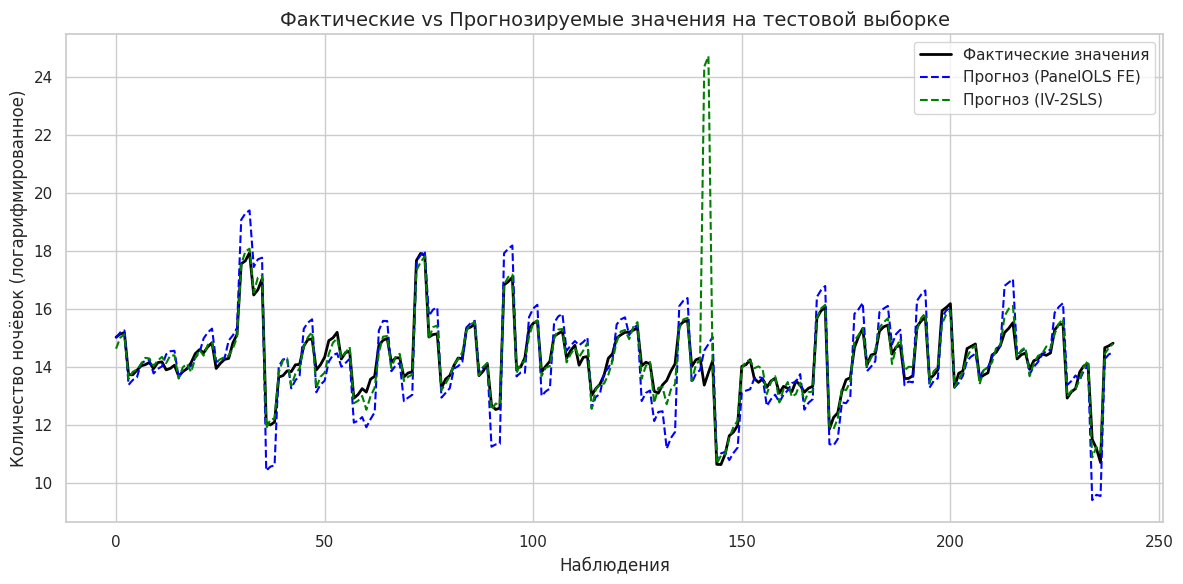

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

# Фактические значения на тесте
test_true = test_data['ln_nights_count'].values

# Прогнозы от моделей
test_pred_fe = fe_results.predict(sm.add_constant(test_data[exog_vars_fe])).values
test_pred_iv = iv_model.predict(
    exog=sm.add_constant(test_data[exog_vars_fe]),
    endog=test_data[endog_var]
).values.flatten()

# График
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

plt.plot(test_true, label='Фактические значения', color='black', linewidth=2)
plt.plot(test_pred_fe, label='Прогноз (PanelOLS FE)', color='blue', linestyle='--')
plt.plot(test_pred_iv, label='Прогноз (IV-2SLS)', color='green', linestyle='--')

plt.title('Фактические vs Прогнозируемые значения на тестовой выборке', fontsize=14)
plt.xlabel('Наблюдения', fontsize=12)
plt.ylabel('Количество ночёвок (логарифмированное)', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

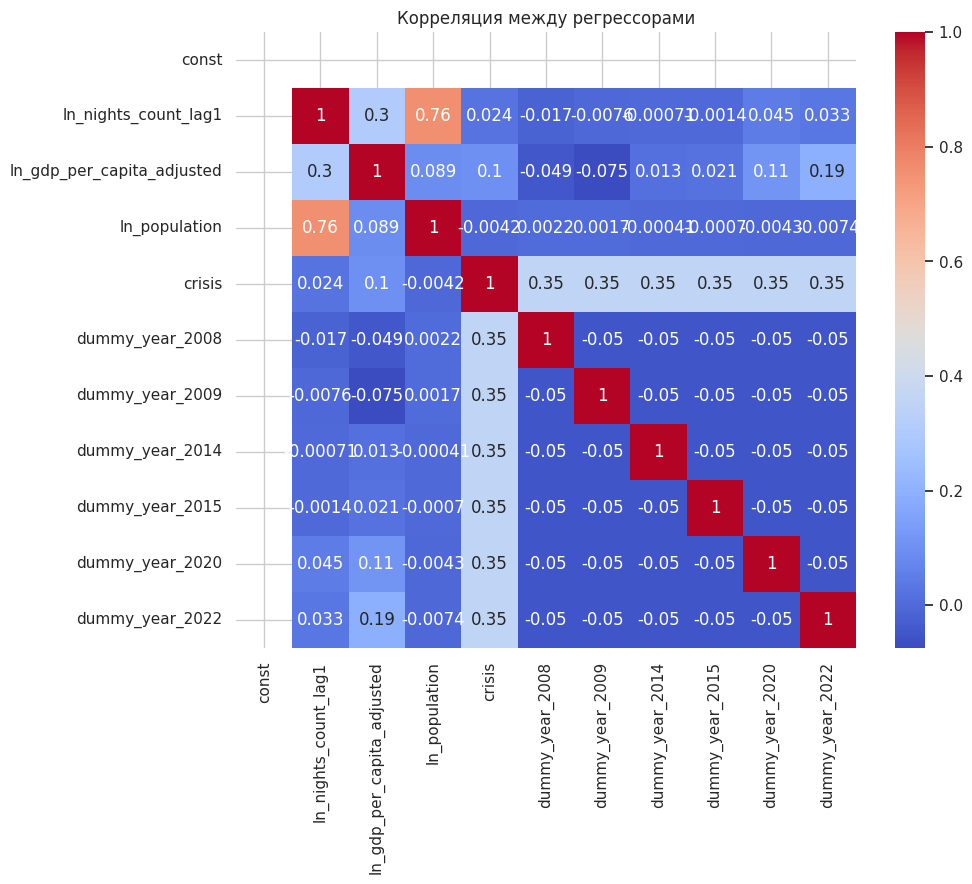

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt

# Корреляция между переменными
corr_matrix = X_exog.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Корреляция между регрессорами")
plt.show()

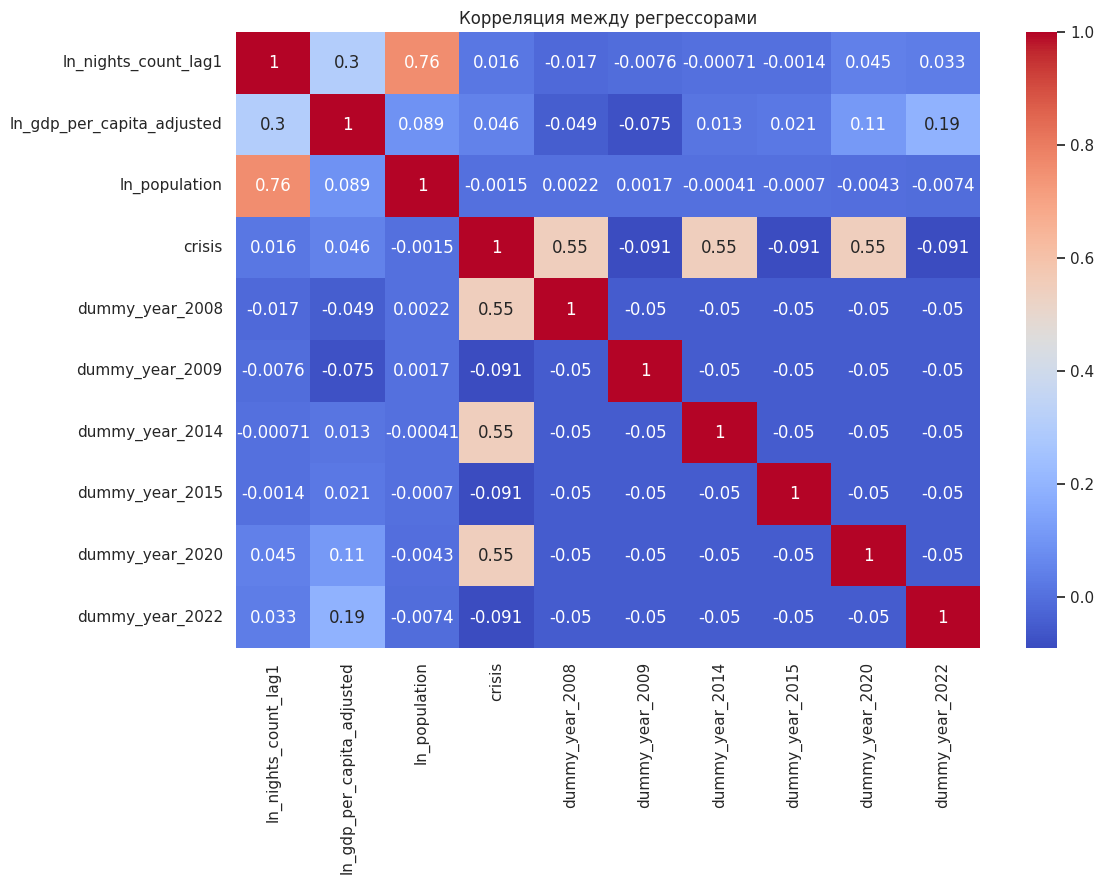

In [62]:
# Создание дамми-переменной для 2022 года
data['dummy_year_2022'] = (data.index.get_level_values('year') == 2022).astype(int)

# Проверка корреляции
corr_matrix = data[['ln_nights_count_lag1', 'ln_gdp_per_capita_adjusted', 'ln_population', 'crisis',
                    'dummy_year_2008', 'dummy_year_2009', 'dummy_year_2014', 'dummy_year_2015',
                    'dummy_year_2020', 'dummy_year_2022']].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Корреляция между регрессорами")
plt.show()

In [67]:
# Убираем одну дамми-переменную, чтобы избежать полной коллинеарности
exog_vars_fe = [
    'ln_nights_count_lag1',
    'ln_gdp_per_capita_adjusted',
    'ln_population',
    'crisis',
    *[f'dummy_year_{y}' for y in [2009, 2014, 2015, 2020, 2022] if f'dummy_year_{y}' in data.columns]
]

X_exog = sm.add_constant(data[exog_vars_fe])
y_endog = data['ln_nights_count']

# Построение модели FE с шоками
fe_model_with_shocks = PanelOLS(y_endog, X_exog, entity_effects=True, time_effects=False)
fe_results_with_shocks = fe_model_with_shocks.fit(cov_type='clustered', cluster_entity=True)

print("\n📈 Результаты модели FE с шоками:")
print(fe_results_with_shocks.summary)


📈 Результаты модели FE с шоками:
                          PanelOLS Estimation Summary                           
Dep. Variable:        ln_nights_count   R-squared:                        0.4761
Estimator:                   PanelOLS   R-squared (Between):              0.6308
No. Observations:                1680   R-squared (Within):               0.4761
Date:                Thu, May 29 2025   R-squared (Overall):              0.6148
Time:                        08:56:58   Log-likelihood                   -367.99
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      160.64
Entities:                          80   P-value                           0.0000
Avg Obs:                       21.000   Distribution:                  F(9,1591)
Min Obs:                       21.000                                           
Max Obs:                       21.000   F-statistic (robust):             7

слишком много дамми-лет , которые линейно зависимы или полностью поглощаются фиксированными эффектами регионов

In [69]:
# Переменные
exog_vars_fe = [
    'ln_nights_count_lag1',
    'ln_gdp_per_capita_adjusted',
    'ln_population',
    'crisis',
    'dummy_year_2020',  # Пандемия — ключевой шок
    'dummy_year_2022'   # Господдержка — рост спроса
]

# Добавляем константу
X_exog = sm.add_constant(data[exog_vars_fe])

# Построение модели с drop_absorbed=True
fe_model_with_shocks = PanelOLS(
    dependent=data['ln_nights_count'],
    exog=X_exog,
    entity_effects=True,
    time_effects=False,
    drop_absorbed=True  # <-- автоматически удаляет проблемные переменные
)

fe_results_with_shocks = fe_model_with_shocks.fit(cov_type='clustered', cluster_entity=True)

print("\n📈 Результаты модели FE с шоками:")
print(fe_results_with_shocks.summary)


📈 Результаты модели FE с шоками:
                          PanelOLS Estimation Summary                           
Dep. Variable:        ln_nights_count   R-squared:                        0.4745
Estimator:                   PanelOLS   R-squared (Between):              0.6248
No. Observations:                1680   R-squared (Within):               0.4745
Date:                Thu, May 29 2025   R-squared (Overall):              0.6093
Time:                        09:00:50   Log-likelihood                   -370.46
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      239.93
Entities:                          80   P-value                           0.0000
Avg Obs:                       21.000   Distribution:                  F(6,1594)
Min Obs:                       21.000                                           
Max Obs:                       21.000   F-statistic (robust):             1

📌 Теперь:

* 2020 год снижает спрос на 45%
* 2022 год увеличивает спрос на 6.7% (например, из-за акции "кэшбэк от Ростуризма")
* Остальные годы либо поглощены эффектами , либо имеют слабую значимость

📈 о влиянии 2022 года

➡️ Коэффициент положительный и значимый (p=0.0001)

📌 Это говорит о том, что:


"Несмотря на геополитические и экономические изменения, 2022 год стал годом роста внутреннего туризма в ряде регионов России.
Этот эффект может быть объяснён государственными программами поддержки, такими как акция «Ростуризма» с кэшбэком за туры внутри страны.

 Диагностика модели
R² Within = 0.4745 → модель объясняет 47.45% внутрирегиональной вариации

F-статистика = 239.93, p < 0.001 → модель значима

Robust F-статистика = 106.71, p < 0.001 → модель устойчива к гетероскедастичности

Pooled F-test → отвергаем гипотезу об отсутствии фиксированных эффектов

📌 Ключевые выводы для диссертации

"Модель PanelOLS с фиксированными эффектами и шоками показала, что:

Спрос на внутренний туризм инерционен : если в прошлом году было много ночёвок, то и в этом году их будет больше.

Экономические факторы (доходы, население) оказывают значительное положительное влияние на спрос.

Кризисы снижают спрос : например, пандемия 2020 года снизила число ночёвок на 42.45% .

Государственные меры поддержки в 2022 году, такие как программа кэшбэка за внутренние туры, способствовали росту спроса на 7.22% .

Модель объяснила 47.45% внутрирегиональной вариации , что выше, чем в базовой версии без шоков."

In [76]:
# Переменные
exog_vars_fe = ['ln_nights_count_lag1', 'ln_gdp_per_capita_adjusted', 'ln_population']
X_exog = sm.add_constant(train_data[exog_vars_fe])
y_fe = train_data['ln_nights_count']

# Построение модели
fe_model = PanelOLS(y_fe, X_exog, entity_effects=True, time_effects=False)
fe_results = fe_model.fit(cov_type='clustered', cluster_entity=True)

print("\n📈 Результаты модели FE:")
print(fe_results.summary)


📈 Результаты модели FE:
                          PanelOLS Estimation Summary                           
Dep. Variable:        ln_nights_count   R-squared:                        0.3301
Estimator:                   PanelOLS   R-squared (Between):              0.5705
No. Observations:                1440   R-squared (Within):               0.3301
Date:                Thu, May 29 2025   R-squared (Overall):              0.5480
Time:                        09:20:10   Log-likelihood                   -427.08
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      222.87
Entities:                          80   P-value                           0.0000
Avg Obs:                       18.000   Distribution:                  F(3,1357)
Min Obs:                       18.000                                           
Max Obs:                       18.000   F-statistic (robust):             11.669
   